# Differential Expression analysis between P1 & P2

1. Run through the 10x Cellranger pipeline and velocyto for single cell RNAseq quatification and using (2) guides quantifiction. all found in the cellranger files folder **bash**
2.  Guide Calling for dual guide. Use repogle method to take molecule.h5 generated by cellranger and py to run through repogle version of guide calling or use cellranger_guidecalling.ipynb for Direct Capture Perturb-Seq dual guide. Formed guide-specific lists of cells.
3. Pseudobulk analysis.
    A. Seperation of guide-specific fastq files. **bash**
    B. Whippet pseudobulk for transcript specific analysis, post UMI deduplication.  **bash**
    C. Transcript quality control. **R**
    D. Whippet result visualisation.
4. Normalisation of adata object and E-distance of KD
5. Check gene and neighboring gene expression
6. Create individual umaps per gene of interest
    A. UMAPs 
    B. Rand Index score
7. Cell phase assignment model from FUCCI-matched single cell paper (GSE146773)
8. **Differential Expression analysis.**
    A. Find the shared P1 and P2 genes. 
    B. Check the shared P1 and P2 across different protospacers with the same A/B and C/D.
9.  CNV Score & Numbat to quantify and Velocity quantification with loom file
10. ESR1-specific analysis from proliferation analysis to rt-qpcr
11.  Spectra analysis and visualisation for pathway enrichment

It performs the Systematic Differential Expression (DE) Analysis requested by reviewers to quantify and compare the transcriptional effects of P1 and P2 promoter knockdowns. 
The notebook identifies which genes change significantly in expression following the knockdown of a specific promoter compared to non-targeting controls (NTC).

Methodology: It utilizes the scanpy.tl.rank_genes_groups function, applying a t-test or Mann-Whitney U test (Z-score) to identify differentially expressed genes (DEGs).

Filtering Criteria: DEGs are strictly filtered based on a $log_{2}FC > 0.5$, an adjusted p-value $< 0.05$, and a requirement that the gene is expressed in $> 10\%$ of the cells in the perturbed population.

In [ ]:
%load_ext autoreload
%matplotlib inline
%autoreload 2
#general
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import hdf5plugin
import gseapy as gp

#form a location
loc="../alt-prom-crispr-fiveprime/"

import seaborn as sns
from tqdm.notebook import tqdm
import scperturb
import sys
sys.path.append(loc+'scripts/')
from apu_analysis import *
import scperturb
import infercnvpy as cnv
from apu_analysis.cell_import import CellPopulation
from IPython.display import clear_output
pd.options.display.float_format = '{:.4f}'.format
import matplotlib.pyplot as plt

#for this python
from scipy.special import rel_entr
import sklearn.cluster as cluster
import umap
from scipy import stats
from scipy.stats import bootstrap
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from numpy import reshape
from numpy import array
from sklearn.decomposition import PCA
import scipy.stats as stats
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from scipy.stats import mannwhitneyu

# Taken from: 
# Adamson, B.A., Norman, T.M., *et al.* "A multiplexed CRISPR screening platform enables systematic dissection of the unfolded protein response", *Cell*, 2016.
# My experiment deals with two KDs- one of the MP, one of the AP using two guides. Positve controls include GINS1 ect. This is a combnatorial KD double for the same gene. No treatments were used

# colours using garvan 
color1 ='#4d00c7'
palecolor1="#b366ff"
color2= '#da3c07'
palecolor2="#ff8954"
color3='#05d3d3'
color4='#c6c7c5'
color4="#434541"
color5="#eb31e1"
color6="#3175eb"
color7="#a7eb31"
color8="#b366ff"
color9="#ff8954"
color10="#35c9d4"

def run_gsea_for_gene(adata, gene):
    print(gene)

    gene_AP = gene + "_AP"
    gene_MP = gene + "_MP"

    # ---------- MP GUIDE ----------
    # get full DE table (NO pval/logFC cutoff for GSEA)
    MP_rank = sc.get.rank_genes_groups_df(adata, group=gene_MP, pval_cutoff=None)

    # make a 2-column ranking like your STIM example:
    #   [names, logfoldchanges]
    mp_rnk = MP_rank.loc[:, ["names", "logfoldchanges"]].dropna()

    # run prerank
    pre_res_mp = gp.prerank(
        rnk=mp_rnk,                 # DataFrame with [gene, score]
        gene_sets="GO_Biological_Process_2021",      # or your favourite collection
        outdir=None,                # don't write files
        seed=123
    )

    # grab the result table
    mp_res_df = pre_res_mp.res2d.copy()
    mp_res_df["Target_Gene"] = gene
    mp_res_df["Guide"] = gene_MP
    # classify direction by NES sign
    mp_res_df["Direction"] = np.where(mp_res_df["NES"] > 0, "Up", "Down")
    gsea_results.append(mp_res_df)

    # ---------- AP GUIDE ----------
    AP_rank = sc.get.rank_genes_groups_df(adata, group=gene_AP, pval_cutoff=None)
    ap_rnk = AP_rank.loc[:, ["names", "logfoldchanges"]].dropna()

    pre_res_ap = gp.prerank(
        rnk=ap_rnk,
        gene_sets="GO_Biological_Process_2021",
        outdir=None,
        seed=123
    )

    ap_res_df = pre_res_ap.res2d.copy()
    ap_res_df["Target_Gene"] = gene
    ap_res_df["Guide"] = gene_AP
    ap_res_df["Direction"] = np.where(ap_res_df["NES"] > 0, "Up", "Down")
    #add together ap_ res_df and mp_res_df
    combined_res_df = pd.concat([mp_res_df, ap_res_df], ignore_index=True)
    return combined_res_df ,pre_res_ap, pre_res_mp

FDR = 0.05
LOG_FOLD_CHANGE = 0.5

# Create the color palette
palette = sns.color_palette([palecolor1,palecolor2,color3,color4])
palette2 = sns.color_palette([color1, color2, palecolor1, palecolor2,color5,color6 ,color7])

# # Create the color palette
# palette = sns.color_palette([color1, color2,color3])
new_palette = sns.color_palette([color1, color2,color1, color2,color1, color2,color1, color2,color1, color2,color1, color2, color3, color4])

from random import randrange
pvalue=0.05

print("Scanpy", sc.__version__)
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Scanpy 1.10.3


In [36]:
%%capture
adata = ad.read_h5ad(loc+"files/adata_normalised_cellcycle.h5ad")
#set the directio
#perform log1p on the data
adata.obs["guide_assignment_simple"]=np.where(((adata.obs["guide_assignment"].str.startswith("non"))|(adata.obs["guide_assignment"].str.startswith("Non"))), "non-targeting", adata.obs["guide_assignment"])
gene_list_select=adata.obs["guide_assignment_simple"][adata.obs["guide_assignment_simple"]!="non-targeting"].drop_duplicates().tolist()
# sc.tl.rank_genes_groups(adata, 'guide_assignment_simple', groups=gene_list_select,reference="non-targeting", method='wilcoxon', use_raw=False)
sc.tl.rank_genes_groups(adata, 'guide_assignment_simple', groups=gene_list_select,reference="non-targeting", method='t-test', use_raw=False)

... storing 'guide_assignment_simple' as categorical


In [37]:
#get the differentially expressed genes
# %%capture 
gene_list=[]
pvalue=0.05
number=1000
sortby="pvals_adj_1"
min_fc=0.5
#get the highly_variable genes
extract_highly_variable_genes=adata.var[adata.var["highly_variable"]==True].index
gene_list_recursive=adata.obs["perturbation"][adata.obs["guide_id"]!="non-targeting_Control"].drop_duplicates().values
#remove ARNT and if gene_A CSNK1E

In [38]:
#get the differentially expressed genes
# %%capture 
gene_list=[]
pvalue=0.05
logFC=0.5
number=1000
sortby="rank_1"
min_fc=1
#get the highly_variable genes
extract_highly_variable_genes=adata.var[adata.var["highly_variable"]==True].index
gene_list_recursive=adata.obs["perturbation"][adata.obs["guide_id"]!="non-targeting_Control"].drop_duplicates().values
#remove ARNT and if gene_A CSNK1E
gene_list_recursive=gene_list_recursive[~gene_list_recursive.isin(["ARNT","CSNK1E"])]
for gene in adata.obs["perturbation"][(adata.obs["guide_id"]!="non-targeting_Control") & (adata.obs["successfulKD"]=="True")].drop_duplicates().values:
    # print(gene)
    #AP
    gene_AP=gene+"_AP"
    if gene_AP not in adata.obs["guide_id"][adata.obs["guide_id"]!="non-targeting_Control"].drop_duplicates().values:
        continue
    elif gene in ["ARNT"]:
        print("ARNT")
    else:
        for promoter in ["MP","AP"]:
            gene_promoter=gene+"_"+promoter+"_"+str(1)
            gene_promoter_2=gene+"_"+promoter+"_"+str(2)
            gene_promoter_random_1=gene_list_recursive[randrange(len(gene_list_recursive))]+"_"+promoter+"_"+str(1)
            gene_promoter_random_2=gene_list_recursive[randrange(len(gene_list_recursive))]+"_"+promoter+"_"+str(2)
            ##form a dataframe with custom colummns 
            #subset random gene from gene list
            protospacer_1= sc.get.rank_genes_groups_df(adata, group=gene_promoter,pval_cutoff=pvalue)
            #order by the absolute value of the logfoldchange
            protospacer_1["abs_logfoldchanges"]=protospacer_1["logfoldchanges"].abs()
            protospacer_1.sort_values(by="abs_logfoldchanges",ascending=False,inplace=True)
            #add a rank column
            protospacer_1["rank"]=range(1,len(protospacer_1)+1)
            protospacer_2= sc.get.rank_genes_groups_df(adata, group=gene_promoter_2,pval_cutoff=pvalue)
            protospacer_2["abs_logfoldchanges"]=protospacer_2["logfoldchanges"].abs()
            protospacer_2.sort_values(by="abs_logfoldchanges",ascending=False,inplace=True)
            #add a rank column
            protospacer_2["rank"]=range(1,len(protospacer_2)+1)
            protospacer_1_random= sc.get.rank_genes_groups_df(adata, group=gene_promoter_random_1,pval_cutoff=pvalue)
            protospacer_1_random["abs_logfoldchanges"]=protospacer_1_random["logfoldchanges"].abs()
            protospacer_1_random.sort_values(by="abs_logfoldchanges",ascending=False,inplace=True)
            #add a rank column
            protospacer_1_random["rank"]=range(1,len(protospacer_1_random)+1)
            protospacer_2_random= sc.get.rank_genes_groups_df(adata, group=gene_promoter_random_2,pval_cutoff=pvalue)
            protospacer_2_random["abs_logfoldchanges"]=protospacer_2_random["logfoldchanges"].abs()
            protospacer_2_random.sort_values(by="abs_logfoldchanges",ascending=False,inplace=True)
            #add a rank column
            protospacer_2_random["rank"]=range(1,len(protospacer_2_random)+1)
            gene_df=protospacer_1.merge(protospacer_2, on="names", how="left", suffixes=('_1', '_2')).dropna()
            #filter for highly variable genes
            gene_df_random_1=protospacer_1.merge(protospacer_1_random, on="names", how="left", suffixes=('_1', '_2')).dropna()
            gene_df_random_2=protospacer_1.merge(protospacer_2_random, on="names", how="left", suffixes=('_1', '_2')).dropna()
            rank_columns=["rank_1","rank_2"]
            #get the correlation for  scores_1 and scores_2 for corr
            correlation_1=gene_df.sort_values(by=sortby, ascending=True)[rank_columns].corr(method='spearman',numeric_only=True)
            correlation_random_1=gene_df_random_1.sort_values(by=sortby, ascending=True)[rank_columns].corr(method='spearman',numeric_only=True)
            correlation_random_2=gene_df_random_2.sort_values(by=sortby, ascending=True)[rank_columns].corr(method='spearman',numeric_only=True)
            #create a row wtht he gene name 
            gene_list_row=[gene,promoter]
            gene_list_row.extend([correlation_1.loc["rank_1","rank_2"],correlation_random_1.loc["rank_1","rank_2"],correlation_random_2.loc["rank_1","rank_2"]])
            gene_list.append(gene_list_row)
            

#flatten list of lists into dataframe
gene_df_final=pd.DataFrame(gene_list, columns=["gene","promoter","scores_1_targeted","scores_1_random","scores_2_random"])     


In [39]:
#get the differentially expressed genes
# %%capture 
# pvalue=0.05
gene_list=[]
gene_list_recursive=adata.obs["perturbation"][adata.obs["guide_id"]!="non-targeting_Control"].drop_duplicates().values
#remove ARNT and if gene_A CSNK1E
gene_list_recursive=gene_list_recursive[~gene_list_recursive.isin(["ARNT","CSNK1E"])]
for gene in adata.obs["perturbation"][(adata.obs["guide_id"]!="non-targeting_Control") & (adata.obs["successfulKD"]=="True")].drop_duplicates().values:
    print(gene)
    #AP
    gene_AP=gene+"_AP"
    if gene_AP not in adata.obs["guide_id"][adata.obs["guide_id"]!="non-targeting_Control"].drop_duplicates().values:
        continue
    elif gene in ["ARNT"]:
        print("ARNT")
    else:
        for promoter in ["MP","AP"]:
            gene_promoter=gene+"_"+promoter+"_"+str(1)
            protospacer_1= sc.get.rank_genes_groups_df(adata, group=gene_promoter,pval_cutoff=pvalue)
            protospacer_1=protospacer_1['names'].values
            
            gene_promoter=gene+"_"+promoter+"_"+str(2)
            protospacer_2= sc.get.rank_genes_groups_df(adata, group=gene_promoter,pval_cutoff=pvalue)
            protospacer_2=protospacer_2['names'].values
            
            gene_promoter=gene_list_recursive[randrange(len(gene_list_recursive))]+"_"+promoter+"_"+str(1)
            protospacer_1_random= sc.get.rank_genes_groups_df(adata, group=gene_promoter,pval_cutoff=pvalue)
            protospacer_1_random=protospacer_1_random["names"].values

            gene_promoter=gene_list_recursive[randrange(len(gene_list_recursive))]+"_"+promoter+"_"+str(2)
            protospacer_2_random= sc.get.rank_genes_groups_df(adata, group=gene_promoter,pval_cutoff=pvalue)
            protospacer_2_random=protospacer_2_random["names"].values
            
            
            overlap = [x for x in protospacer_1 if x in protospacer_2]
            overlap_random_1 = [x for x in overlap if x in protospacer_1_random]
            overlap_random_2 = [x for x in overlap if x in protospacer_2_random]
            #if overlap protospacer_1 protospacer_2 overlap_random_2 overlap_random_1 = 0 set to 1
            # print(protospacer_1,protospacer_2,overlap,overlap_random_1,overlap_random_2)
            try: 
                overlap_1=len(overlap)/len(protospacer_1)
                overlap_2=len(overlap)/len(protospacer_2)
                overlap_random_1=len(overlap_random_1)/len(protospacer_1_random)
                overlap_random_2=len(overlap_random_2)/len(protospacer_2_random)
            except ZeroDivisionError:
                overlap_1=0
                overlap_2=0
                overlap_random_1=0
                overlap_random_2=0
            
            gene_df=pd.DataFrame([[gene,promoter,overlap_1,overlap_2,overlap_random_1,overlap_random_2]])
            # gene_df_details=pd.DataFrame([[gene,promoter,protospacer_1,protospacer_2,overlap,len(protospacer_1),len(protospacer_2),len(overlap)]])

            # print(gene_df.shape)
            gene_list.append(gene_df)
            # break


# col_names=["Gene","Promoter","Protospacer_1","Protospacer_2","Overlap","Protospacer_Random_1","Protospacer_Random_2"]
#add col_names
col_names=["Gene","Promoter","Overlap_1","Overlap_2","Overlap_Random_1","Overlap_Random_2"]
all=pd.DataFrame(pd.concat(gene_list))
all.columns=col_names


AHCYL1
SP1
TGIF1
YWHAZ
P4HB
NCOR2
JARID2
ESR1
PA2G4
GPBP1
DHX30
SAFB
NFE2L2
CHD8
SIN3A
PSMC5
RC3H2
ZNF3
GTF2F1
ADAR
NR2F2
BZW1
FHL2
SET
MYBBP1A
CUX1
NBN
CALR
APP
STAG2
PKM
BRIP1
GATA3
RBM47


In [40]:
#get the tests between two unpaired parametric groups
#melt for random
all_melt=all.melt(id_vars=["Gene","Promoter"])
all.index=all["Gene"]+"_"+all["Promoter"]   
print(stats.ttest_ind(all["Overlap_1"],all["Overlap_2"],equal_var=False))
print(stats.ttest_ind(all["Overlap_Random_1"],all["Overlap_Random_2"],equal_var=False))
print(stats.ttest_ind(all["Overlap_1"],all["Overlap_Random_1"],equal_var=False))
print(stats.ttest_ind(all["Overlap_2"],all["Overlap_Random_2"],equal_var=False))

TtestResult(statistic=-1.200758436011414, pvalue=0.23196364293947955, df=133.97197243239725)
TtestResult(statistic=-0.8170297166398177, pvalue=0.4153781706070453, df=132.49121568852897)
TtestResult(statistic=10.428675297500293, pvalue=2.596256035375967e-18, df=114.67625808804517)
TtestResult(statistic=10.723518386158062, pvalue=2.9404501919466304e-19, df=120.79414195321442)


A central goal of this notebook is to determine the degree of overlap between the pathways regulated by different promoters of the same gene.



Limited Overlap: The analysis reveals that for most genes, there is minimal overlap between the DEGs affected by P1 versus P2 knockdown. This supports the conclusion that alternative promoters regulate largely distinct downstream pathways.






Z-Score Correlation: For the small subset of shared DEGs, the notebook calculates Pearson correlations of Z-scores. As shown in the study, these shared genes typically show high positive correlations, indicating a coherent regulatory response even when the number of shared genes is small.

In [ ]:
#plot the overlap between the two guides
sns.set(style="white")
sns.set_context("talk")
fig, ax = plt.subplots(figsize=(8, 5))
#show the percentage over "Overlap_length"/"Protospacer_1_length"
sns.kdeplot(data=all_melt,x="value",hue="variable",palette=new_pallete,  
)
#save plot
plt.savefig(loc+"figures/overlap_gene_signature.pdf")
gene_list_select=adata.obs["guide_id"][adata.obs["guide_id"]!="non-targeting_Control"].drop_duplicates().values
sc.tl.rank_genes_groups(adata, 'guide_id', groups=gene_list_select.to_list(),reference="non-targeting_Control", method='t-test')
genelist=adata.obs['guide_id'].drop_duplicates().tolist()

In [42]:
%%capture
# comp_gene_list MP vs AP summary table for each candidate gene
# all_genes_df full DE results for all guides (MP and AP)
# all_genes_df_filt statistically significant DEGs used for downstream signature analysis

sc.tl.rank_genes_groups(adata, 'guide_id',groups=genelist, reference="non-targeting_Control", use_raw=False, pts=0.1)

#get target gene logfoldchanges
#get the differentially expressed genes 
gene_list=[]
comp_gene_list=[]

for gene in adata.obs["perturbation"][(adata.obs["guide_id"]!="non-targeting_Control")& (adata.obs["successfulKD"]=="True")].drop_duplicates().values:
    # print(gene)
    #AP
    gene_AP=gene+"_AP"
    gene_MP=gene+"_MP"

    if gene_AP not in adata.obs["guide_id"][(adata.obs["guide_id"]!="non-targeting_Control")& (adata.obs["successfulKD"]=="True")].drop_duplicates().values:
        continue
    else:
        ##form a dataframe with custom colummns 
        MP = sc.get.rank_genes_groups_df(adata, group=gene_MP)
        MP_filt = MP[(MP["names"]==gene)]
        AP = sc.get.rank_genes_groups_df(adata, group=gene_AP)        
        AP_filt = AP[(AP["names"]==gene)]
        #do it for every gene 
        MP["targeted_gene"]=gene_MP
        AP["targeted_gene"]=gene_AP
        gene_list.append(MP)
        gene_list.append(AP)
        promoter_line=[gene,MP["scores"].values[0],MP["logfoldchanges"].values[0],MP["pvals_adj"].values[0],AP["scores"].values[0],AP["logfoldchanges"].values[0],AP["pvals_adj"].values[0]]
        comp_gene_list.append(promoter_line)
#convert to dataframe
comp_gene_list=pd.DataFrame(comp_gene_list, columns=["gene","MP_zscore","MP_logfoldchange","MP_pvalue","AP_zscore","AP_logfoldchange","AP_pvalue"])

#merge all gene dfs
all_genes_df=pd.DataFrame(pd.concat(gene_list))
#change the column names
all_genes_df.columns=["gene","scores","logfoldchanges","pvals","pvals_adj","pct_nz_group","targeted_gene"]
#filter for logfoldchange > 0.5 and pvalue < 0.05
all_genes_df_filt=all_genes_df[(all_genes_df["pvals_adj"]<0.05) & (all_genes_df["logfoldchanges"].abs()>0.5)]


In [43]:
%%capture
# Run DE once
# all  → Summary of MP/AP DEG counts & correlations (one row per target gene)
# directional_genes_df → Up- and down-regulated DEG signatures per target
# all_filt → Summary table filtered for successful KD

gene_list = []          # per-target summary (MP/AP counts, overlap, correlation)
comp_gene_list = []     # full DE tables for each MP/AP guide
directional_genes = []  # per-target, per-direction summary (Up / Down)

# Cache valid guides to avoid recomputing each loop
valid_guides = adata.obs.loc[
    adata.obs["guide_id"] != "non-targeting_Control", "guide_id"
].drop_duplicates().values

perturbations = adata.obs.loc[
    adata.obs["guide_id"] != "non-targeting_Control", "perturbation"
].drop_duplicates().values

for gene in perturbations:
    print(gene)

    gene_AP = gene + "_AP"
    gene_MP = gene + "_MP"

    # skip if there is no AP guide for this gene
    if gene_AP not in valid_guides:
        continue

    # ------- MP -------
    MP = sc.get.rank_genes_groups_df(adata, group=gene_MP, pval_cutoff=0.05)
    MP = MP[MP["logfoldchanges"].abs() > 0.5]
    MP_names = MP["names"].values

    MP_up = MP[MP["logfoldchanges"] > 0]
    MP_up_names = MP_up["names"].values

    MP_down = MP[MP["logfoldchanges"] < 0]
    MP_down_names = MP_down["names"].values

    # ------- AP -------
    AP = sc.get.rank_genes_groups_df(adata, group=gene_AP, pval_cutoff=0.05)
    AP = AP[AP["logfoldchanges"].abs() > 0.5]
    AP_names = AP["names"].values

    AP_up = AP[AP["logfoldchanges"] > 0]
    AP_up_names = AP_up["names"].values

    AP_down = AP[AP["logfoldchanges"] < 0]
    AP_down_names = AP_down["names"].values

    # ------- Overlaps -------
    overlap       = [x for x in MP_names      if x in AP_names]
    overlap_up    = [x for x in MP_up_names   if x in AP_up_names]
    overlap_down  = [x for x in MP_down_names if x in AP_down_names]

    # correlation of scores for overlapping genes (MP vs AP)
    correlation_value = None
    if len(overlap) > 1:
        corr_df = MP[MP["names"].isin(overlap)].merge(
            AP[AP["names"].isin(overlap)],
            on="names",
            how="inner",
            suffixes=("_MP", "_AP")
        )
        corr_mat = corr_df[["scores_MP", "scores_AP"]].corr(
            method="pearson", numeric_only=True
        )
        correlation_value = corr_mat.loc["scores_MP", "scores_AP"]
    else:
        correlation_value = float("nan")

    # ------- per-gene summary row -------
    gene_row = pd.DataFrame(
        [[
            gene,
            MP_names,
            AP_names,
            overlap,
            len(MP_names),
            len(AP_names),
            len(overlap),
            correlation_value
        ]]
    )
    gene_list.append(gene_row)

    # ------- directional (Up / Down) rows -------
    gene_direction_df = pd.DataFrame(
        [
            [
                gene,
                MP_up_names,
                AP_up_names,
                overlap_up,
                len(MP_up_names),
                len(AP_up_names),
                len(overlap_up),
                "Up",
            ],
            [
                gene,
                MP_down_names,
                AP_down_names,
                overlap_down,
                len(MP_down_names),
                len(AP_down_names),
                len(overlap_down),
                "Down",
            ],
        ]
    )
    directional_genes.append(gene_direction_df)

    # ------- full DE tables with guide labels -------
    MP["Guide"] = gene_MP
    AP["Guide"] = gene_AP
    comp_gene_list.append(MP)
    comp_gene_list.append(AP)

# ---------- build final dataframes ----------

col_names = [
    "Target_Gene",
    "MP_Genes",
    "AP_Genes",
    "Overlap_Genes",
    "MP_Gene_Num",
    "AP_Gene_Num",
    "Overlap_Gene_Num",
    "correlation_value",
]
all = pd.DataFrame(pd.concat(gene_list, ignore_index=True))
all.columns = col_names

# only directional
directional_genes_df = pd.DataFrame(
    pd.concat(directional_genes, ignore_index=True)
)
directional_genes_df.columns = [
    "Target_Gene",
    "MP_Genes",
    "AP_Genes",
    "Overlap_Genes",
    "MP_Gene_Num",
    "AP_Gene_Num",
    "Overlap_Gene_Num",
    "Direction",
]

# filter to successful KDs
successful = adata.obs.loc[
    adata.obs["successfulKD"] == "True", "gene"
].drop_duplicates().values

directional_genes_df = directional_genes_df[
    directional_genes_df["Target_Gene"].isin(successful)
]

all_filt = all[all["Target_Gene"].isin(successful)].reset_index(drop=True)

# save if you want
# all_filt.to_csv(loc+"files/singlecell_shortread_analysis/differential_exp_list.csv")
all_filt.to_csv(loc+"files/singlecell_shortread_analysis/differential_exp_list_corr.csv")
comp_gene_df = pd.concat(comp_gene_list, ignore_index=True)
comp_gene_df.to_csv(loc+"files/singlecell_shortread_analysis/differential_exp_fulltable.csv", index=False)

In [44]:
directional_genes_df.to_csv(loc+"files/singlecell_shortread_analysis/differential_exp_directional_genes.csv", index=False)

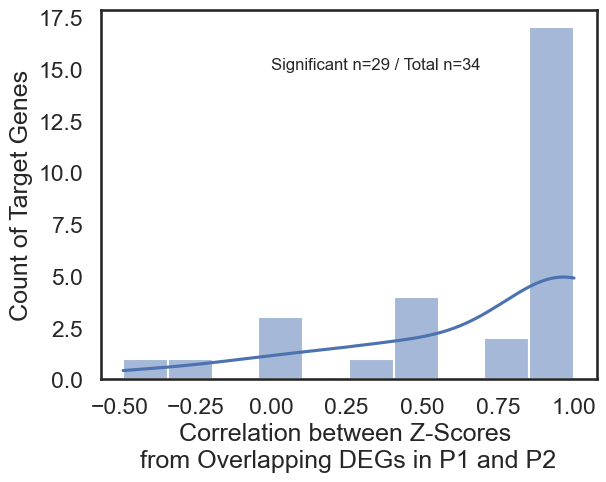

In [45]:
#plot all_filt 
#plot the correlation_value
sns.histplot(data=all_filt, x="correlation_value", bins=10, kde=True)
plt.xlabel("Correlation between Z-Scores \n from Overlapping DEGs in P1 and P2 ")
plt.ylabel("Count of Target Genes")
#add the number of genes with a value not na and all the genes
num_genes=len(all_filt)
signif_genes=all_filt[all_filt["correlation_value"].notna()]
num_signif_genes=len(signif_genes)
plt.text(0, 15, f'Significant n={num_signif_genes} / Total n={num_genes}', fontsize=12)
# all_filt
#save 
plt.savefig(loc+"figures/correlation_DEG_Zscores_MP_AP.pdf")

In [46]:
#save directional_genes_df to csv
directional_genes_df.to_csv(loc+"files/singlecell_shortread_analysis/differential_exp_directional_genes.csv", index=False)

/var/folders/r_/bqnt2f_d6919cz7v1yzx2ykc0000gn/T/ipykernel_22880/435962864.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/r_/bqnt2f_d6919cz7v1yzx2ykc0000gn/T/ipykernel_22880/435962864.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


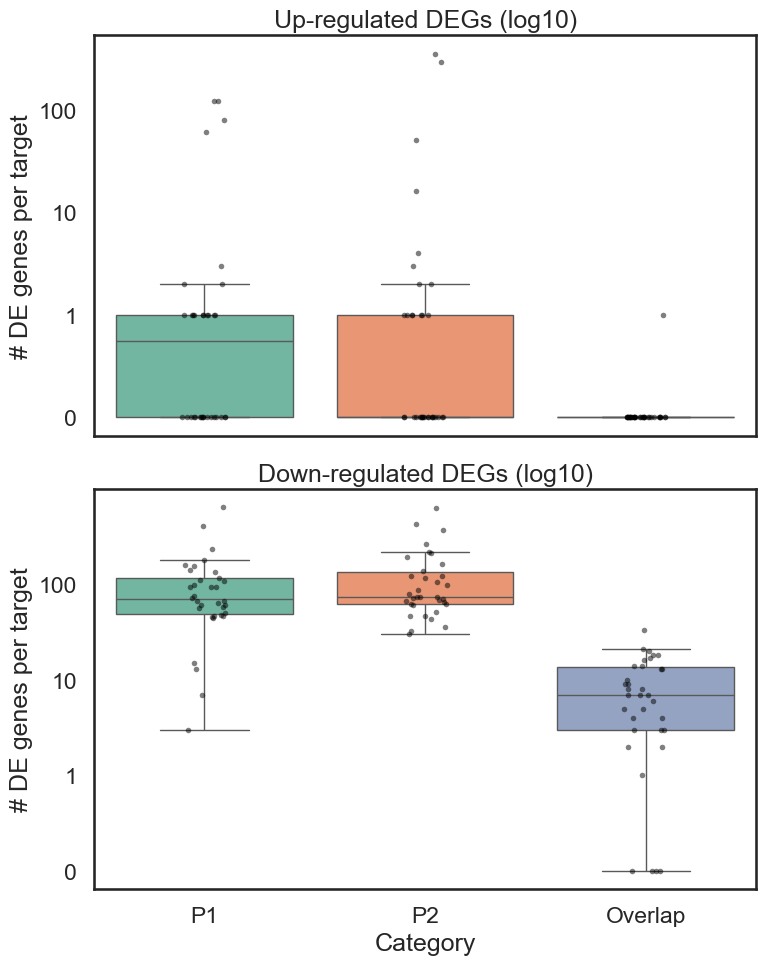

In [47]:

# long format for plotting distributions
long = directional_genes_df.melt(
    id_vars=["Target_Gene", "Direction"],
    value_vars=["MP_Gene_Num", "AP_Gene_Num", "Overlap_Gene_Num"],
    var_name="Category",
    value_name="N_genes"
)

# optional: nicer labels
long["Category"] = long["Category"].map({
    "MP_Gene_Num": "P1",
    "AP_Gene_Num": "P2",
    "Overlap_Gene_Num": "Overlap"
})

# Add log10 transform column
long["log10_N_genes"] = np.log10(long["N_genes"]+1e-7)  # replaces 0 by 1
#add log appropriate long["N_genes"] by assigning it as +0.0000001
#drop duplicates
long["N_adj"] = long["N_genes"].replace(0, 0.1)

long = long.drop_duplicates()

fig, axes = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
#make the background axes lines
sns.set_style("whitegrid") 

# ---- UP ----
sns.boxplot(
    data=long[long["Direction"] == "Up"],
    x="Category",
    y="N_adj",
    showfliers=False,
    palette="Set2",
    ax=axes[0]
)
sns.stripplot(
    data=long[long["Direction"] == "Up"],
    x="Category",
    y="N_adj",
    color="black",
    alpha=0.5,
    size=4,
    ax=axes[0]
)
axes[0].set_title("Up-regulated DEGs (log10)")
axes[0].set_ylabel("# DE genes per target")
axes[0].set_xlabel("")
axes[0].set_yscale('log')

# ---- DOWN ----
sns.boxplot(
    data=long[long["Direction"] == "Down"],
    x="Category",
    y="N_adj",
    palette="Set2",
    showfliers=False,
    ax=axes[1]
)
sns.stripplot(
    data=long[long["Direction"] == "Down"],
    x="Category",
    y="N_adj",
    color="black",
    alpha=0.5,
    size=4,
    ax=axes[1]
)
axes[1].set_yscale('log')
axes[1].set_title("Down-regulated DEGs (log10)")
axes[1].set_ylabel("# DE genes per target")
axes[1].set_xlabel("Category")
#change 10-1 to 0 on y axis
tick_vals = [0.1, 1, 10, 100]
for ax in axes:
    ax.set_yticks(tick_vals)
    ax.set_yticklabels(["0", "1", "10", "100"])

#repeat for both axes

#save as pdf
plt.savefig(loc+"figures/DEG_counts_per_target_promoter.pdf")
plt.tight_layout()
plt.show()

In [48]:
#find the top overlapping genes
long[(long["Direction"] == "Down")&(long["Category"]=="Overlap")].sort_values(by="N_genes", ascending=False).head(6)

,Target_Gene,Direction,Category,N_genes,log10_N_genes,N_adj
185,MYBBP1A,Down,Overlap,33,1.5185,33.0000
151,ESR1,Down,Overlap,21,1.3222,21.0000
201,GATA3,Down,Overlap,20,1.3010,20.0000
203,RBM47,Down,Overlap,18,1.2553,18.0000
169,RC3H2,Down,Overlap,18,1.2553,18.0000
149,JARID2,Down,Overlap,17,1.2304,17.0000


In [49]:
#can check that there are no genes with logfoldchange between -0.5 and 0.5 ad that pvals_adj
print(all_genes_df_filt[(all_genes_df_filt["logfoldchanges"].abs()<=0.5) & (all_genes_df_filt["pvals_adj"]<0.05)].shape)

#chec number of genes with sig. DEG all_genes_df_filt ESR1_MP ESR1_AP
#plot the distribution of logfoldchanges for ESR1_MP and ESR1_AP
all_genes_df_esr1=all_genes_df_filt[all_genes_df_filt["targeted_gene"].isin(["ESR1_MP","ESR1_AP"])]
all_genes_df_esr1["Direction"]=np.where(all_genes_df_esr1["logfoldchanges"]>0, "Up","Down")
#check the number of MP and AP genes per target gene and their overlap using 
number_of_genes=all_genes_df_esr1.groupby(["targeted_gene","Direction"]).size().unstack(fill_value=0)
#see the number of gene that overlap between MP and AP
overlap_genes=all_genes_df_esr1[all_genes_df_esr1["targeted_gene"]=="ESR1_MP"]["gene"].isin(all_genes_df_esr1[all_genes_df_esr1["targeted_gene"]=="ESR1_AP"]["gene"])
print(number_of_genes)
print("Number of overlapping genes between ESR1_MP and ESR1_AP:", overlap_genes.sum())

(0, 7)
Direction      Down   Up
targeted_gene           
ESR1_AP         634  355
ESR1_MP         154    0
Number of overlapping genes between ESR1_MP and ESR1_AP: 21


/var/folders/r_/bqnt2f_d6919cz7v1yzx2ykc0000gn/T/ipykernel_22880/1044356788.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_genes_df_esr1["Direction"]=np.where(all_genes_df_esr1["logfoldchanges"]>0, "Up","Down")


<Figure size 640x480 with 0 Axes>

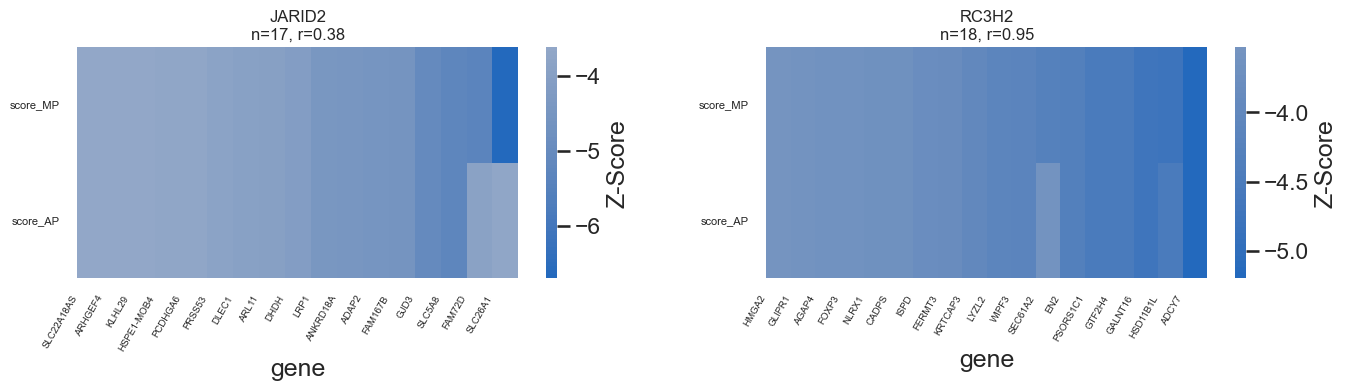

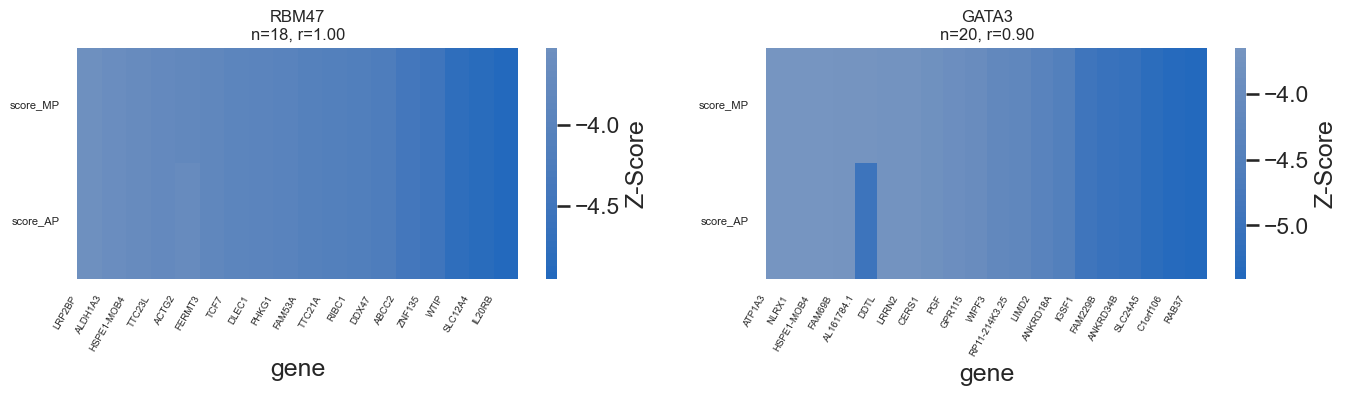

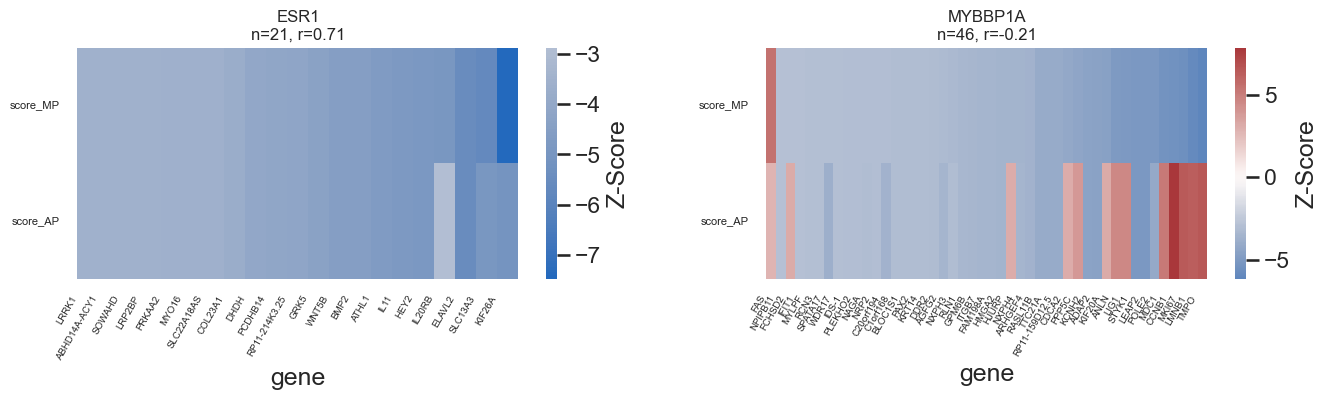

In [50]:


genes_of_interest = ["JARID2", "RC3H2", "RBM47","GATA3", "ESR1", "MYBBP1A"]

plt.subplots_adjust(hspace=0.35, wspace=0.25)

# Determine grid shape
n = len(genes_of_interest)
ncols = 2
nrows = int(np.ceil(n / ncols))



for i in range(nrows):
    fig, axes = plt.subplots(
        1, ncols,
        figsize=(8 * ncols, 3 ),
        sharey=False   # <-- keep y shared, but NOT x
    )
    axes = axes.flatten()
    #sub genes_of_interest list for current row
    row_genes_of_interest = genes_of_interest[i*ncols:(i+1)*ncols]
    for ax, tg in zip(axes, row_genes_of_interest):

        mp = (
            all_genes_df_filt.loc[
                all_genes_df_filt["targeted_gene"] == f"{tg}_MP",
                ["gene", "scores"]
            ].rename(columns={"scores": "score_MP"})
        )
        ap = (
            all_genes_df_filt.loc[
                all_genes_df_filt["targeted_gene"] == f"{tg}_AP",
                ["gene", "scores"]
            ].rename(columns={"scores": "score_AP"})
        )

        overlap = mp.merge(ap, on="gene", how="inner")

        if overlap.empty:
            ax.set_axis_off()
            ax.set_title(f"{tg}: no overlapping genes", fontsize=10)
            continue

        r = overlap["score_MP"].corr(overlap["score_AP"])

        # draw heatmap
        sns.heatmap(
            overlap.set_index("gene").T,
            cmap="vlag",
            center=0,
            cbar_kws={"label": "Z-Score"},
            ax=ax
        )

        # ---- force ALL gene labels to show ----
        genes = overlap["gene"].tolist()
        ax.set_xticks(np.arange(len(genes)) + 0.05)        # centers of cells
        ax.set_xticklabels(genes, rotation=60, ha="right", fontsize=7)
        ax.tick_params(axis='x', which='major', pad=2)
        #remove yticklabels
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=8)

        ax.set_title(f"{tg}\nn={len(overlap)}, r={r:.2f}", fontsize=12)

    plt.subplots_adjust(hspace=0.35, wspace=0.25)
    #save
    plt.savefig(loc+f"figures/DEG_Zscore_heatmap_MP_AP_row{i+1}.pdf")
    plt.show()
    


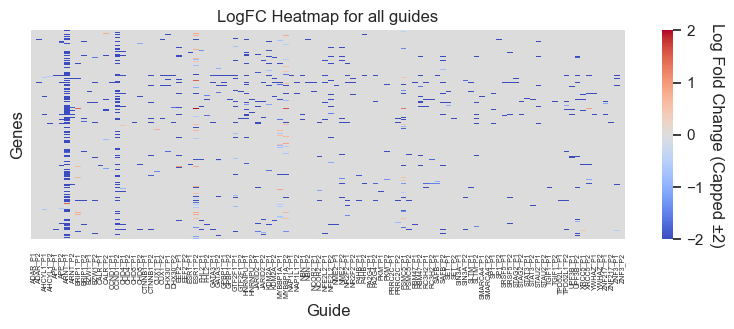

In [51]:
#change MP to P1 and AP to P2
comp_gene_df["Guide"] = comp_gene_df["Guide"].str.replace("_MP", "_P1")
comp_gene_df["Guide"] = comp_gene_df["Guide"].str.replace("_AP", "_P2")
pivot_df = comp_gene_df.pivot_table(
    index="names",
    columns="Guide",
    values="logfoldchanges",
    aggfunc="median"
)

pivot_df = pivot_df.fillna(0)

sns.set(style="white")
#make figure larger
plt.figure(figsize=(8, 4))
#make max and min +2 and -2
vmax = 2
vmin = -2

sns.heatmap(
    pivot_df,
    cmap="coolwarm",
    center=0,
    linewidths=0,
    xticklabels=True,
    yticklabels=False,   # set to True if you want labels (but 17k genes = unreadable)
    vmax=vmax,
    vmin=vmin
)
plt.title("LogFC Heatmap for all guides")
plt.xlabel("Guide")
plt.ylabel("Genes")
#remove vadj
plt.tight_layout()
#make x smaller size
plt.xticks(fontsize=5)
#add colorbar label titlee saying Log Fold Change
cbar = plt.gcf().axes[-1]
cbar.set_ylabel('Log Fold Change (Capped ±2)', rotation=270, labelpad=15)
plt.show()


(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
         18.5,  19.5,  20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,
         27.5,  28.5,  29.5,  30.5,  31.5,  32.5,  33.5,  34.5,  35.5,
         36.5,  37.5,  38.5,  39.5,  40.5,  41.5,  42.5,  43.5,  44.5,
         45.5,  46.5,  47.5,  48.5,  49.5,  50.5,  51.5,  52.5,  53.5,
         54.5,  55.5,  56.5,  57.5,  58.5,  59.5,  60.5,  61.5,  62.5,
         63.5,  64.5,  65.5,  66.5,  67.5,  68.5,  69.5,  70.5,  71.5,
         72.5,  73.5,  74.5,  75.5,  76.5,  77.5,  78.5,  79.5,  80.5,
         81.5,  82.5,  83.5,  84.5,  85.5,  86.5,  87.5,  88.5,  89.5,
         90.5,  91.5,  92.5,  93.5,  94.5,  95.5,  96.5,  97.5,  98.5,
         99.5, 100.5, 101.5, 102.5, 103.5, 104.5, 105.5]),
 [Text(0, 0.5, 'ADAR_P1'),
  Text(0, 1.5, 'ADAR_P2'),
  Text(0, 2.5, 'AHCYL1_P1'),
  Text(0, 3.5, 'AHCYL1_P2'),
  Text(0, 4.5, 'APP_P1'),
  Text(0, 5.5, 'APP_P2

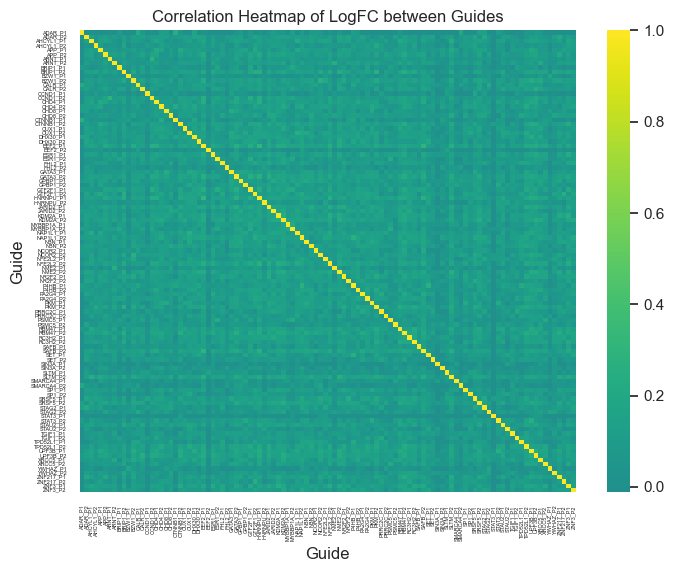

In [52]:
#make a correlation between the logfoldchanges for MP vs AP for all genes
corr=pivot_df.corr(method='pearson',numeric_only=True)
#plot the correlation as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr,
    cmap="viridis",
    center=0,
    linewidths=0,
    xticklabels=True,
    yticklabels=True

)
plt.title("Correlation Heatmap of LogFC between Guides")
plt.xlabel("Guide")
plt.ylabel("Guide")
plt.xticks(fontsize=4)
plt.yticks(fontsize=4)


Pathway and GO Enrichment Analysis
To move from individual gene lists to biological functions, the notebook conducts pathway enrichment analysis.


GSEA and pyGSEA: It performs pre-ranked Gene Set Enrichment Analysis (GSEA) using the GO:BP (Gene Ontology: Biological Process) database.



NES Differences: The code quantifies differences between P1 and P2 at the pathway level by calculating the difference in Normalized Enrichment Scores (NES)

In [ ]:
# list to collect per-guide GSEA results
gsea_results = []

# cache valid guides to avoid recomputing
valid_guides = adata.obs.loc[
    adata.obs["guide_id"] != "non-targeting_Control", "guide_id"
].drop_duplicates().values

# list of perturbed genes
perturbations = adata.obs.loc[
    adata.obs["guide_id"] != "non-targeting_Control", "perturbation"
].drop_duplicates().values

for gene in perturbations:
    print(gene)

    gene_AP = gene + "_AP"
    gene_MP = gene + "_MP"

    # skip if no AP guide for this gene
    if gene_AP not in valid_guides:
        continue

    # ---------- MP GUIDE ----------
    # get full DE table (NO pval/logFC cutoff for GSEA)
    MP_rank = sc.get.rank_genes_groups_df(adata, group=gene_MP, pval_cutoff=None)

    # make a 2-column ranking like your STIM example:
    #   [names, logfoldchanges]
    mp_rnk = MP_rank.loc[:, ["names", "logfoldchanges"]].dropna()

    # run prerank
    pre_res_mp = gp.prerank(
        rnk=mp_rnk,                 # DataFrame with [gene, score]
        gene_sets="GO_Biological_Process_2021",      # or your favourite collection
        outdir=None,                # don't write files
        seed=123
    )

    # grab the result table
    mp_res_df = pre_res_mp.res2d.copy()
    mp_res_df["Target_Gene"] = gene
    mp_res_df["Guide"] = gene_MP
    # classify direction by NES sign
    mp_res_df["Direction"] = np.where(mp_res_df["NES"] > 0, "Up", "Down")
    gsea_results.append(mp_res_df)

    # ---------- AP GUIDE ----------
    AP_rank = sc.get.rank_genes_groups_df(adata, group=gene_AP, pval_cutoff=None)
    ap_rnk = AP_rank.loc[:, ["names", "logfoldchanges"]].dropna()

    pre_res_ap = gp.prerank(
        rnk=ap_rnk,
        gene_sets="GO_Biological_Process_2021",
        outdir=None,
        seed=123
    )

    ap_res_df = pre_res_ap.res2d.copy()
    ap_res_df["Target_Gene"] = gene
    ap_res_df["Guide"] = gene_AP
    ap_res_df["Direction"] = np.where(ap_res_df["NES"] > 0, "Up", "Down")
    gsea_results.append(ap_res_df)

gsea_results.head()

In [ ]:
if len(gsea_results) > 0:
    gsea_results_df = pd.concat(gsea_results, ignore_index=True)
else:
    gsea_results_df = pd.DataFrame()
successful_guides = adata.obs["guide_id"][adata.obs["successfulKD"]=='True'].unique()



In [ ]:
#filter for only genes in the whippet siuccessful KD
gsea_results_df = gsea_results_df[gsea_results_df["Guide"].isin(successful_guides)].reset_index(drop=True)
# Clean up pathway names a bit (optional)
gsea_results_df["Pathway"] = gsea_results_df["Term"].str.replace(r" Homo sapiens.*", "", regex=True)
gsea_results_df["Condition"] = gsea_results_df["Guide"].apply(lambda x: "P1" if "_MP" in x else "P2")

# Filter to significant pathways
sig = gsea_results_df[(gsea_results_df["NOM p-val"] < 0.05) & (gsea_results_df["FDR q-val"] < 0.25)].copy()

# Keep only pathways that appear in ≥2 target genes (shared)
pathway_counts = sig.groupby("Pathway")["Target_Gene"].nunique()
shared_pathways = pathway_counts[pathway_counts >= 2].index
sig_shared = sig[sig["Pathway"].isin(shared_pathways)].copy()

# This is your “significant shared list”
sig_shared.to_csv("significant_shared_pathways.csv", index=False)
print(sig_shared.head())
#save sig
sig.to_excel(loc+"figures/significant_genes.xlsx")

          Name                                               Term      ES  \
4075   prerank  positive regulation of potassium ion transport...  0.7394   
8155   prerank  positive regulation of cellular component move... -0.9718   
8160   prerank  negative regulation of endopeptidase activity ... -0.9330   
10185  prerank  positive regulation of biosynthetic process (G...  0.7262   
16299  prerank  positive regulation of phospholipase activity ... -0.9546   

          NES NOM p-val FDR q-val FWER p-val Tag % Gene %  \
4075   1.8924    0.0025    0.2356     0.2740  4/16  5.02%   
8155  -1.6374    0.0000    0.0601     0.0600  3/15  0.59%   
8160  -1.6019    0.0064    0.1928     0.4290  5/20  2.34%   
10185  1.9967    0.0000    0.0651     0.0590  5/25  3.00%   
16299 -1.6885    0.0050    0.1416     0.1250  3/15  1.78%   

                                   Lead_genes Target_Gene     Guide Direction  \
4075              GABBR2;ADRA2A;KCNMB4;KCNMB3         SP1    SP1_MP        Up   
8155    

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/var/folders/r_/bqnt2f_d6919cz7v1yzx2ykc0000gn/T/ipykernel_22880/1666908462.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=pathway_counts_count.values, x=pathway_counts_count.index, palette="viridis")
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


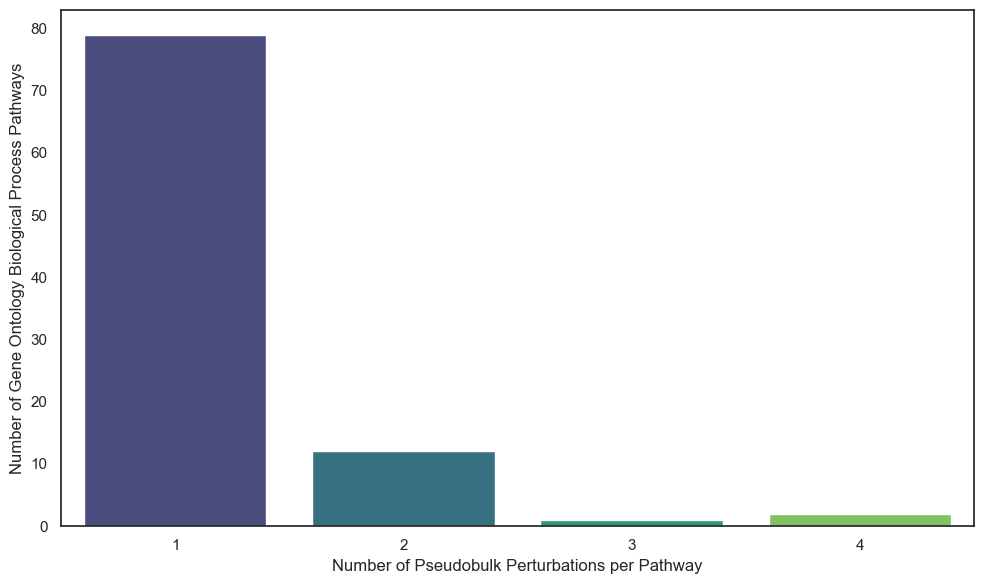

In [59]:
#use pathway_counts to count the number of pathways with the number fo genes 
pathway_counts_count = pathway_counts.value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(y=pathway_counts_count.values, x=pathway_counts_count.index, palette="viridis")
plt.ylabel("Number of Gene Ontology Biological Process Pathways")
plt.xlabel("Number of Pseudobulk Perturbations per Pathway")
plt.tight_layout()
plt.show()

   Target_Gene  Mean_NES_P1  Mean_NES_P2  NES_Difference
0          SP1       1.8865          NaN             NaN
1        TGIF1      -1.6060       1.9967         -3.6027
2         P4HB      -1.6885          NaN             NaN
3        NCOR2          NaN      -1.6075             NaN
4       JARID2      -1.4687      -1.6524          0.1836
5         ESR1       1.9448       0.7594          1.1854
6        PA2G4      -1.6153          NaN             NaN
7        GPBP1          NaN       1.9496             NaN
8        DHX30          NaN      -0.2122             NaN
9         SAFB          NaN      -1.4168             NaN
10        CHD8          NaN      -1.5998             NaN
11       SIN3A      -0.9079      -1.7137          0.8058
12       PSMC5      -1.7132       1.8945         -3.6077
13      GTF2F1       1.9189      -1.5914          3.5103
14        ADAR      -0.8903          NaN             NaN
15       NR2F2      -1.5661          NaN             NaN
16        BZW1       1.0284    

/var/folders/r_/bqnt2f_d6919cz7v1yzx2ykc0000gn/T/ipykernel_22880/2520638475.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=nes_diff_df, x="Target_Gene", y="NES_Difference", palette="coolwarm")


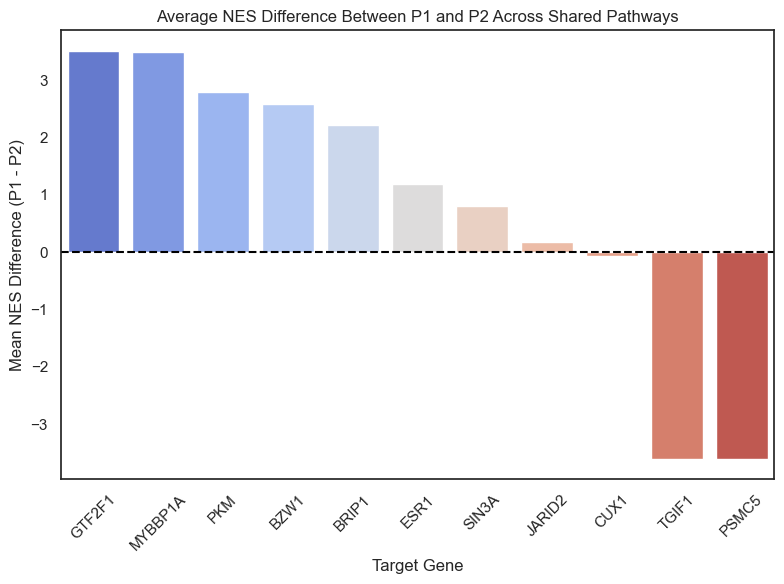

In [61]:
#find the average difference NES between P1 and P2 for each gene 
nes_diff_list = []
for gene in sig["Target_Gene"].drop_duplicates().values:
    gene_df = sig[sig["Target_Gene"] == gene]
    # separate P1 and P2
    p1_df = gene_df[gene_df["Condition"] == "P1"]
    p2_df = gene_df[gene_df["Condition"] == "P2"]
    
    #just calculate thge mean NES difference
    mean_nes_p1 = p1_df["NES"].mean()
    mean_nes_p2 = p2_df["NES"].mean()
    nes_diff = mean_nes_p1 - mean_nes_p2
    nes_diff_list.append({
        "Target_Gene": gene,
        "Mean_NES_P1": mean_nes_p1,
        "Mean_NES_P2": mean_nes_p2,
        "NES_Difference": nes_diff
    })
nes_diff_df = pd.DataFrame(nes_diff_list)
print(nes_diff_df)
#plot the NES difference
plt.figure(figsize=(8, 6))
#order difference nes_diff_df
nes_diff_df = nes_diff_df.sort_values("NES_Difference", ascending=False)
#remove genes with nan values
nes_diff_df = nes_diff_df[nes_diff_df["NES_Difference"].notna()]
sns.barplot(data=nes_diff_df, x="Target_Gene", y="NES_Difference", palette="coolwarm")
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Target Gene")
plt.ylabel("Mean NES Difference (P1 - P2)")
plt.title("Average NES Difference Between P1 and P2 Across Shared Pathways")
plt.xticks(rotation=45)
plt.tight_layout()
#save as a pdf
plt.savefig(loc+"figures/mean_NES_difference_P1_P2.pdf")
plt.show()


In [ ]:
#run for a single gene
for gene_of_interest in nes_diff_df["Target_Gene"].values:
    gsea_esr1_df,pre_res_ap, pre_res_mp = run_gsea_for_gene(adata, gene_of_interest)
    #add together res2d from pre_res_ap and pre_res_mp
    pre_res_ap.res2d["Promoter"] = "P2"
    pre_res_mp.res2d["Promoter"] = "P1"
    combined_res2d = pd.concat([pre_res_ap.res2d, pre_res_mp.res2d], ignore_index=True)
    from gseapy.scipalette import SciPalette
    sci = SciPalette()
    NbDr = sci.create_colormap()
    #add new column name 'Adjusted P-value' from FDR q-val
    combined_res2d["Adjusted P-value"] = combined_res2d["NOM p-val"]
    combined_res2d["Direction"] = np.where(combined_res2d["NES"] > 0, "Up", "Down")
    combined_res2d["Promoter_Direction"] = combined_res2d["Promoter"] + "_" + combined_res2d["Direction"]
    combined_res2d = combined_res2d[(combined_res2d["NOM p-val"] < 0.05) & (combined_res2d["FDR q-val"] < 0.25)].copy()
    ax = gp.dotplot(combined_res2d,figsize=(3,5),
                    x='Promoter_Direction',
                    x_order = ["P1_Up","P1_Down","P2_Up","P2_Down"],
                    title=f'GSEA Dotplot for {gene_of_interest}',
                    cmap = NbDr.reversed(),
                    size=3,
                    show_ring=True)
    ax.set_xlabel("")
    #make the size larger for plt.savefig
    plt.gcf().set_size_inches(6,10)
    plt.savefig(f"gsea_dotplot_{gene_of_interest}.pdf")
    #save plot 
    plt.show()

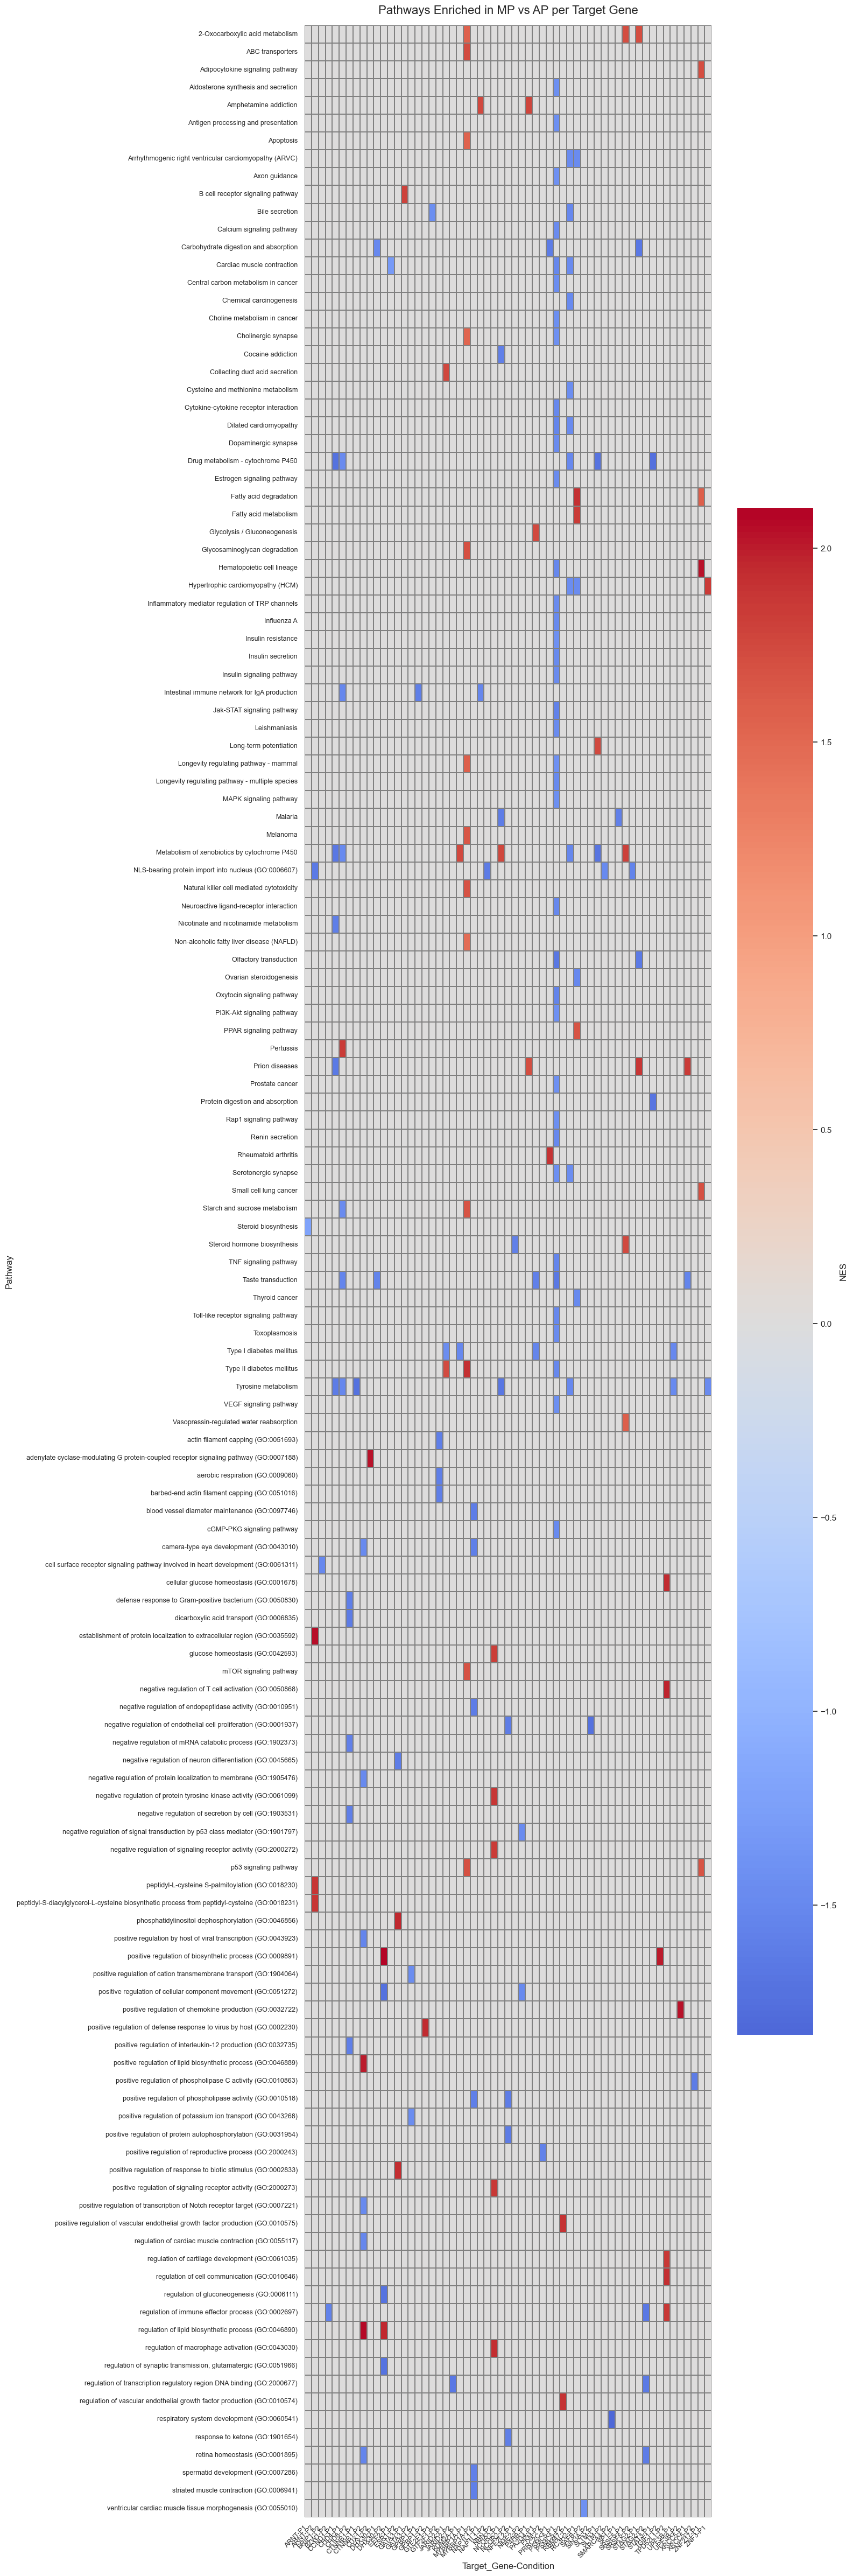

In [23]:
all_comp=pd.DataFrame(pd.concat(comp_gene_list))
all_comp.columns=MP.columns
all_comp["Promoter"]=all_comp["Guide"].str.split("_").str.get(1)
all_comp["Target_Gene"]=all_comp["Guide"].str.split("_").str.get(0)
all_comp_mean=all_comp.groupby("Target_Gene").agg({'logfoldchanges': 'mean'})
all_comp_mean.reset_index(inplace=True)
all_comp_mean.columns=["Target_Gene","logfoldchanges_mean"]
all_comp=all_comp.merge(all_comp_mean,on="Target_Gene")
all_comp_mean=all_comp.groupby("Target_Gene").agg({'Target_Gene':"count"}).rename(columns={"Target_Gene":"Count"})
all_comp_mean.reset_index(inplace=True)
all_comp=all_comp.merge(all_comp_mean,on="Target_Gene")
all_comp=all_comp.sort_values(by="Guide")
all_comp.to_csv(loc+"files/singlecell_shortread_analysis/differential_exp_list_full.csv")

In [ ]:

all["Mutual_Exclusivity"]=all["Overlap_Gene_Num"]/(all["MP_Gene_Num"]+all["AP_Gene_Num"])

n_term=pd.read_table("alt-prom-crispr-fiveprime/reference/all_pivot_simple_nterm.txt")
n_term=all.merge(n_term, right_on="Gene_symbol",left_on="Target_Gene")

n_term=n_term[["MP_Gene_Num","AP_Gene_Num","Overlap_Gene_Num","Mutual_Exclusivity","Ensembl_ID","Gene_symbol","Nterminus_Change"]]
# all_comp_pivot
all_comp_all=all_comp.merge(n_term, left_on="Target_Gene", right_on="Gene_symbol" ,how="outer")
all_comp_all=all_comp_all.sort_values("Nterminus_Change",ascending=True)